In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

from nlp_adversarial_attacks.utils.file_io import load_json

In [2]:
def extract_infos(metrics_path):
    parts = metrics_path.parts
    infos = {
        "dataset": parts[-6],
        "target_model": parts[-5],
        "setting": parts[-4],
        "classification_model": parts[-3],
        "feature_setting": parts[-2],
    }
    expe_json = load_json(Path(metrics_path.parents[2], "settings.json"))
    assert infos["dataset"] == expe_json["target_dataset"]
    assert infos["target_model"] == expe_json["target_model"]
    assert infos["setting"] == expe_json["setting"]
    infos["is_binary"] = expe_json["is_binary"]

    return infos

In [3]:
all_experiments_dir = Path("data_tcab/detection-experiments/")

df_list = []
for metrics_path in all_experiments_dir.glob("**/metrics.json"):
    print(metrics_path)
    infos = extract_infos(metrics_path)
    metrics = load_json(metrics_path)
    infos.update(metrics)
    df_list.append(infos)

df = pd.DataFrame(df_list)

data_tcab\detection-experiments\allocine\distilcamembert\clean_vs_all\LGB\all\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\clean_vs_all\LGB\bert\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\clean_vs_all\LGB\bert+tp\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\clean_vs_all\LGB\bert+tp+lm\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\clean_vs_all\LR\all\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\clean_vs_all\LR\bert\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\clean_vs_all\LR\bert+tp\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\clean_vs_all\LR\bert+tp+lm\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\clean_vs_all\RF\all\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\clean_vs_all\RF\bert\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\clean_vs_all\R

In [4]:
for column in df.columns:
    if "confusion_matrix" in column:
        df[column] = df[column].apply(lambda x: np.array(x))

In [5]:
df

,dataset,target_model,setting,classification_model,feature_setting,is_binary,train_accuracy,train_balanced_accuracy,train_confusion_matrix,train_roc_auc,...,test_accuracy,test_balanced_accuracy,test_confusion_matrix,test_roc_auc,best_params,label_classes,important_features,feature_names,coef,intercept
0,allocine,distilcamembert,clean_vs_all,LGB,all,True,0.999720,0.999720,"[[5355, 3], [0, 5358]]",0.999720,...,0.960221,0.946230,"[[1920, 89], [26, 856]]",0.963110,None,"[clean, perturbed]",None,"[lm_perplexity_region0, lm_perplexity_region1,...",None,None
1,allocine,distilcamembert,clean_vs_all,LGB,bert,True,0.917413,0.918074,"[[4809, 549], [336, 5022]]",0.917413,...,0.705984,0.653667,"[[1581, 428], [422, 460]]",0.654250,None,"[clean, perturbed]",None,"[lm_bert_0, lm_bert_1, lm_bert_2, lm_bert_3, l...",None,None
2,allocine,distilcamembert,clean_vs_all,LGB,bert+tp,True,0.910694,0.911228,"[[4976, 382], [575, 4783]]",0.910694,...,0.759253,0.716026,"[[1663, 346], [350, 532]]",0.715475,None,"[clean, perturbed]",None,"[avg_word_length_mean_region0, avg_word_length...",None,None
3,allocine,distilcamembert,clean_vs_all,LGB,bert+tp+lm,True,0.936543,0.937335,"[[5132, 226], [454, 4904]]",0.936543,...,0.820131,0.787558,"[[1741, 268], [252, 630]]",0.790443,None,"[clean, perturbed]",None,"[lm_perplexity_region0, lm_perplexity_region1,...",None,None
4,allocine,distilcamembert,clean_vs_all,LR,all,True,0.999720,0.999720,"[[5356, 2], [1, 5357]]",0.999720,...,0.955033,0.943508,"[[1929, 80], [50, 832]]",0.951745,None,"[clean, perturbed]","{'perturbed': [['lm_proba_var_region3', 0.7192...","[lm_perplexity_region0, lm_perplexity_region1,...","[[0.181196666686869, -0.19476096786130434, -0....",[1.254434404178427]
5,allocine,distilcamembert,clean_vs_all,LR,bert,True,0.768570,0.768909,"[[4213, 1145], [1335, 4023]]",0.768570,...,0.726046,0.686141,"[[1533, 476], [316, 566]]",0.702395,None,"[clean, perturbed]","{'perturbed': [['lm_bert_312', 0.7754413271866...","[lm_bert_0, lm_bert_1, lm_bert_2, lm_bert_3, l...","[[0.31331039610159184, -0.09117493766923299, 0...",[0.1405581261745512]
6,allocine,distilcamembert,clean_vs_all,LR,bert+tp,True,0.788820,0.789377,"[[4344, 1014], [1249, 4109]]",0.788820,...,0.745763,0.706204,"[[1573, 436], [299, 583]]",0.721987,None,"[clean, perturbed]","{'perturbed': [['lm_bert_312', 0.7282489231406...","[avg_word_length_mean_region0, avg_word_length...","[[0.47524197304050986, -0.15363985047513282, -...",[0.19691391762579835]
7,allocine,distilcamembert,clean_vs_all,LR,bert+tp+lm,True,0.828761,0.829352,"[[4554, 804], [1031, 4327]]",0.828761,...,0.773781,0.735230,"[[1636, 373], [281, 601]]",0.747871,None,"[clean, perturbed]","{'perturbed': [['lm_rank_mean_region3', 0.7989...","[lm_perplexity_region0, lm_perplexity_region1,...","[[-0.0838779480378248, -0.03912633225887978, -...",[0.36454948929808684]
8,allocine,distilcamembert,clean_vs_all,RF,all,True,0.959220,0.959635,"[[5059, 299], [138, 5220]]",0.959220,...,0.945694,0.927293,"[[1882, 127], [30, 852]]",0.951385,None,"[clean, perturbed]",None,"[lm_perplexity_region0, lm_perplexity_region1,...",None,None
9,allocine,distilcamembert,clean_vs_all,RF,bert,True,0.707540,0.710797,"[[4124, 1234], [1900, 3458]]",0.707540,...,0.672086,0.628552,"[[1450, 559], [389, 493]]",0.640355,None,"[clean, perturbed]",None,"[lm_bert_0, lm_bert_1, lm_bert_2, lm_bert_3, l...",None,None


In [6]:
feature_setting_order = ["bert", "bert+tp", "bert+tp+lm", "all"]


def sort_feature_setting(serie):
    return serie.map(lambda x: feature_setting_order.index(x))

In [7]:
df.groupby("feature_setting").mean().sort_index(key=sort_feature_setting)

C:\Users\Baptiste\AppData\Local\Temp\ipykernel_33164\2329125307.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("feature_setting").mean().sort_index(key=sort_feature_setting)


,is_binary,train_accuracy,train_balanced_accuracy,train_roc_auc,validation_accuracy,validation_balanced_accuracy,validation_roc_auc,test_accuracy,test_balanced_accuracy,test_roc_auc
feature_setting,,,,,,,,,,
bert,0.5,0.738773,0.737204,0.797841,0.535174,0.528884,0.656918,0.522887,0.467915,0.665667
bert+tp,0.5,0.781289,0.777509,0.812897,0.615180,0.606612,0.706224,0.576098,0.515006,0.706133
bert+tp+lm,0.5,0.814193,0.812551,0.850286,0.674672,0.667442,0.772216,0.689784,0.578879,0.770348
all,0.5,0.930620,0.931660,0.986220,0.826415,0.813460,0.955099,0.890003,0.770416,0.955414


In [8]:
EXPERIMENT_SETTINGS = df.setting.unique()

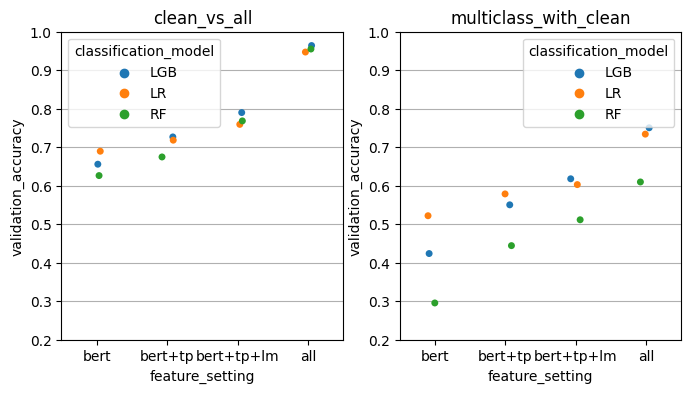

In [9]:
fig, axes = plt.subplots(
    1, len(EXPERIMENT_SETTINGS), figsize=(4 * len(EXPERIMENT_SETTINGS), 4)
)

for i, setting in enumerate(EXPERIMENT_SETTINGS):
    sns.stripplot(
        data=df[df.setting == setting],
        x="feature_setting",
        y="validation_accuracy",
        hue="classification_model",
        order=feature_setting_order,
        ax=axes[i],
    )
    axes[i].set_title(setting)

for ax in axes:
    ax.set_ylim(0.2, 1)
    ax.grid(axis="y")

### Confusion matrix

In [10]:
df["label_classes"] = df["label_classes"].apply(lambda x: tuple(x))
assert (df.groupby("is_binary")["label_classes"].nunique() == 1).all()

In [11]:
BINARY_CLASSES = df[df["is_binary"]].iloc[0]["label_classes"]
MULTI_CLASSES = df[~df["is_binary"]].iloc[0]["label_classes"]

In [12]:
def plot_confusion_matrix_serie(serie, title=""):
    if serie[0].shape[0] == 2:
        classes = BINARY_CLASSES
        figsize = (4 * len(serie), 4)
        xticks_rotation = False
    else:
        classes = MULTI_CLASSES
        figsize = (6 * len(serie), 6.5)
        xticks_rotation = True
    fig, axes = plt.subplots(1, len(serie), figsize=figsize)
    for i, (index, cm) in enumerate(serie.items()):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot(ax=axes[i], colorbar=False, cmap="Blues")
        axes[i].set_title(index)
        xlabels = axes[i].get_xticklabels()
        if xticks_rotation:
            axes[i].set_xticklabels(
                xlabels, rotation=40, ha="right", rotation_mode="anchor"
            )
    plt.tight_layout()
    fig.suptitle(title)
    plt.show()

In [13]:
cm_serie = (
    df[df.setting == "clean_vs_all"]
    .groupby("feature_setting")["validation_confusion_matrix"]
    .mean()
    .sort_index(key=sort_feature_setting)
)
cm_serie

feature_setting
bert          [[1334.6666666666667, 443.3333333333333], [776...
bert+tp       [[1440.0, 338.0], [706.6666666666666, 1071.333...
bert+tp+lm    [[1498.6666666666667, 279.3333333333333], [530...
all           [[1692.3333333333333, 85.66666666666667], [74....
Name: validation_confusion_matrix, dtype: object

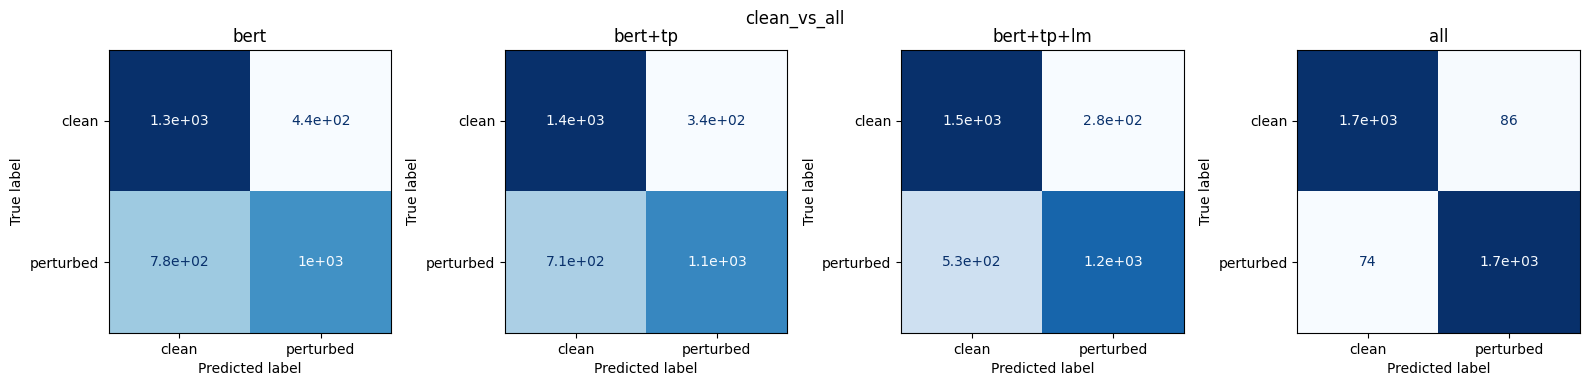

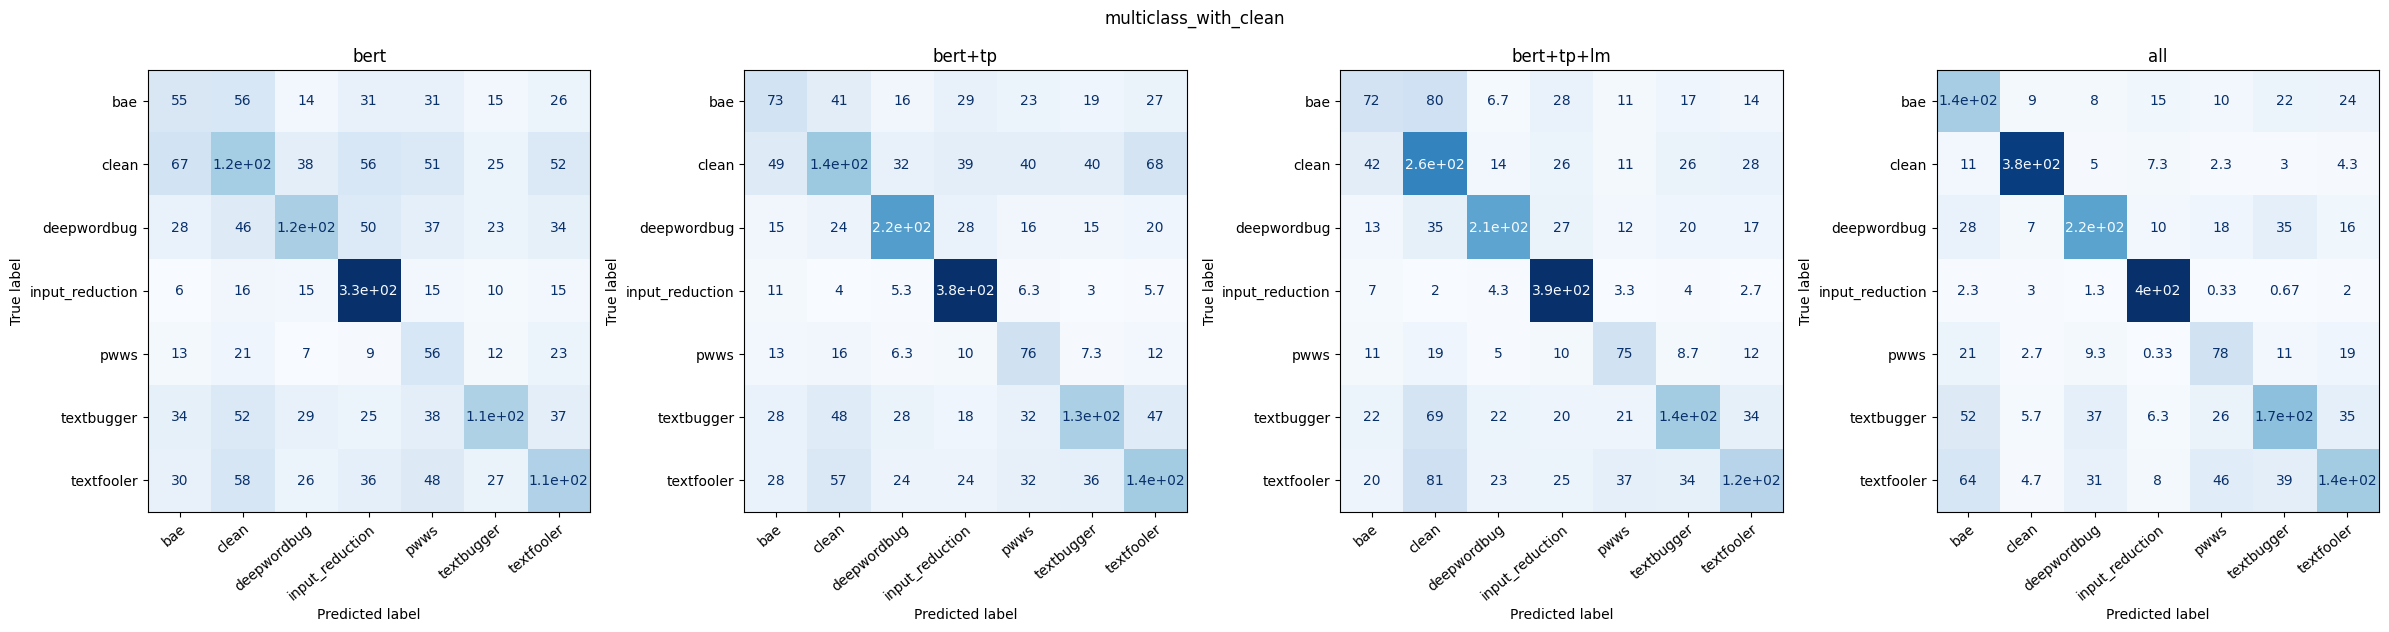

In [14]:
for setting in EXPERIMENT_SETTINGS:
    cm_serie = (
        df[df.setting == setting]
        .groupby("feature_setting")["validation_confusion_matrix"]
        .mean()
        .sort_index(key=sort_feature_setting)
    )
    plot_confusion_matrix_serie(cm_serie, title=setting)

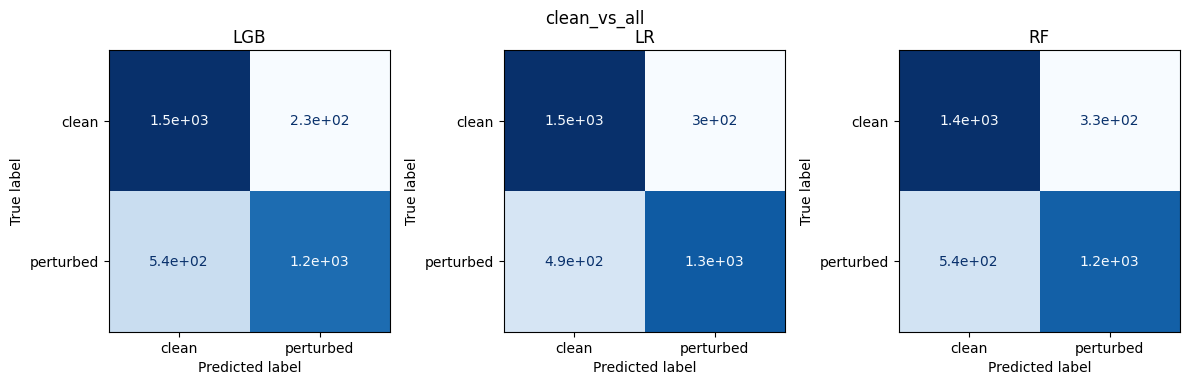

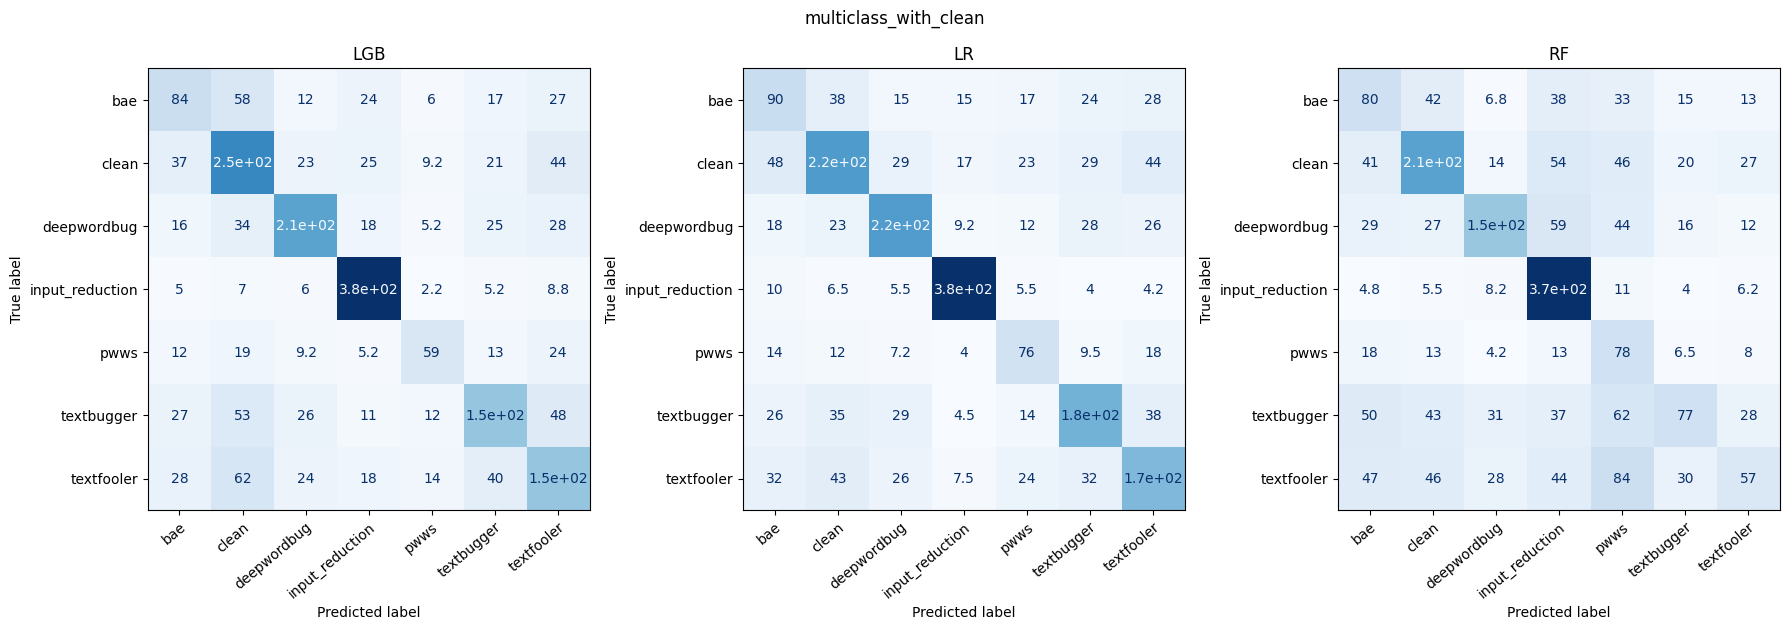

In [15]:
for setting in EXPERIMENT_SETTINGS:
    cm_serie = (
        df[df.setting == setting]
        .groupby("classification_model")["validation_confusion_matrix"]
        .mean()
    )
    plot_confusion_matrix_serie(cm_serie, title=setting)